# DataJoint tutorial

### The code for the interactive notebook is available here: https://github.com/ivust/datajoint_tutorial

We run a lot of experiments and keeping track of them is hard (at least for me)
![](figures/folders.png)

## What do we want from an experiment tracking tool?

### Storage and quering

- Make sure all the results are accessible and nothing is lost.
- Maybe raw data storage should be supported as well.
- Easy querying. For example, something like this is inconvenient:
```python
for param1 in list_of_param1_values:
    for param2 in list_of_param2_values:
        for param3 in list_of_param3_values:
            results_file_path = get_file_path(root_folder, param1, param2, param3)
            results = load_results(results_file_path)
            ...
```
- For example, $0.5 \leq \text{param1} \leq 1.5$ and $\text{param2} \geq 10 \cdot \text{param1}$ need to be coded as `if...else` statements
- A table might be a better option

![](figures/table.png)

- A table needs to be manually kept up-to-date and stored somewhere. Also how do we store different types of data? Links to files?
- What about pipelines, where the results of one experiment are inputs to the next one?

### There is a good solution to storage and querying problem

Databases! For example, relational databases with SQL language for querying

![](figures/database_cartoon.png)

![](figures/params_database.jpg)

Querying is much easier than in manual looping over the file system:
```sql
SELECT res1
FROM results
    JOIN param1 ON (param1.id = results.id_p1)
    JOIN param2 ON (param2.id = results.id_p2)
WHERE
    param1.value >= 0.5 AND 
    param1.value <= 1.5 AND 
    param2.value >= param1.value * 10
```

- DataJoint is an easy-to-use wrapper on top of a SQL database. 

### Computation

- DataJoint is not just an SQL database wrapper. It also allows us to define computational pipeline (a bit lime Makefile).
- The database tables can be automatically populated based on the data saved in their dependent tables.
- The auto population jobs are tracked in a global table enabling parallel computations (see later).

## An example

Let's train a neural network on MNIST digits and use DataJoint to keep track of the results.

In [1]:
import torch.optim as optim
from datajoint_tutorial.torch_network import Net, get_dataloaders, train, test

In [2]:
net = Net(num_features_1=32, num_features_2=64, dropout_prob=0.25)

In [3]:
train_loader, test_loader = get_dataloaders(batch_size=4)

In [4]:
import matplotlib.pyplot as plt

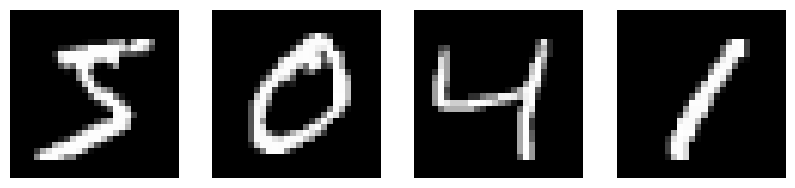

In [5]:
for (imgs, labels) in train_loader:
    break
    
plt.figure(figsize=(10, 3))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(imgs[i,0], cmap="gray")
    plt.axis("off")

In [6]:
net_output = net(imgs)
net_output.shape

torch.Size([4, 10])

### Setting up DataJoint schema

In [7]:
import datajoint as dj

In [8]:
# Database connection

dj.config['database.host'] = 'localhost'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'password'

In [9]:
# schema.drop()

In [10]:
# Schema is a collection of tables

schema = dj.schema('tutorial', locals())

[2023-04-25 19:14:26,144][INFO]: Connecting root@localhost:3306
[2023-04-25 19:14:26,214][INFO]: Connected root@localhost:3306


Our model contains the following parameters:

- Number of features in the first and second layer
- Dropout probability
- Optimizer learning rate
- Number of optimization epochs

In [11]:
@schema
class NumFeatures(dj.Manual):
    definition = """
    features_config_id  : tinyint # so-called primary key, must be unique
    ---
    num_features_1      : int
    num_features_2      : int
    """

In [12]:
NumFeatures()

"features_config_id so-called primary key, must be unique",num_features_1,num_features_2


In [13]:
NumFeatures().insert1([1, 32, 32])

In [14]:
NumFeatures()

"features_config_id so-called primary key, must be unique",num_features_1,num_features_2
1,32,32


In [15]:
NumFeatures().insert([
    [2, 16, 32],
    [3, 32, 64],
    [4, 64, 64]
])

In [16]:
NumFeatures()

"features_config_id so-called primary key, must be unique",num_features_1,num_features_2
1,32,32
2,16,32
3,32,64
4,64,64


In [17]:
some_features = NumFeatures() & 'num_features_1 > 20'

In [18]:
some_features

"features_config_id so-called primary key, must be unique",num_features_1,num_features_2
1,32,32
3,32,64
4,64,64


In [19]:
some_features = NumFeatures() & 'num_features_1 > num_features_2'

In [20]:
some_features

"features_config_id so-called primary key, must be unique",num_features_1,num_features_2


In [21]:
some_features = NumFeatures() & 'num_features_1 = num_features_2'

In [22]:
some_features

"features_config_id so-called primary key, must be unique",num_features_1,num_features_2
1,32,32
4,64,64


In [23]:
some_features.fetch()

array([(1, 32, 32), (4, 64, 64)],
      dtype=[('features_config_id', '<i8'), ('num_features_1', '<i8'), ('num_features_2', '<i8')])

In [24]:
some_features.fetch(as_dict=True)

[{'features_config_id': 1, 'num_features_1': 32, 'num_features_2': 32},
 {'features_config_id': 4, 'num_features_1': 64, 'num_features_2': 64}]

In [25]:
some_features.fetch(format="frame")

,num_features_1,num_features_2
features_config_id,,
1,32,32
4,64,64


In [26]:
some_features = NumFeatures() & dict(features_config_id=1, some_key="some_value")

In [27]:
some_features

"features_config_id so-called primary key, must be unique",num_features_1,num_features_2
1,32,32


In [28]:
some_features.fetch1()

{'features_config_id': 1, 'num_features_1': 32, 'num_features_2': 32}

In [29]:
@schema
class DropoutProb(dj.Lookup):
    definition = """
    dropout_config_id  : tinyint # so-called primary key, must be unique
    ---
    dropout_prob       : float
    """
        
    contents = [[1, 0.25], [2, 0.5]]

In [30]:
DropoutProb()

"dropout_config_id so-called primary key, must be unique",dropout_prob
1,0.25
2,0.5


In [31]:
@schema
class LearningRate(dj.Lookup):
    definition = """
    lr_config_id  : tinyint # so-called primary key, must be unique
    ---
    lr            : float
    """
        
    contents = [[1, 1e-3], [2, 1e-2]]

In [32]:
LearningRate()

"lr_config_id so-called primary key, must be unique",lr
1,0.001
2,0.01


In [33]:
@schema
class NumEpochs(dj.Lookup):
    definition = """
    epochs_config_id  : tinyint # so-called primary key, must be unique
    ---
    epochs            : int
    """
        
    contents = [[1, 1], [2, 10], [3, 50]]

In [34]:
NumEpochs()

"epochs_config_id so-called primary key, must be unique",epochs
1,1
2,10
3,50


In [35]:
NumEpochs() & dict(epochs_config_id=2)

"epochs_config_id so-called primary key, must be unique",epochs
2,10


In [36]:
NumEpochs() & [dict(epochs_config_id=2), dict(epochs_config_id=3)]

"epochs_config_id so-called primary key, must be unique",epochs
2,10
3,50


In [37]:
NumEpochs() & ['epochs_config_id=2', dict(epochs_config_id=3)]

"epochs_config_id so-called primary key, must be unique",epochs
2,10
3,50


In [38]:
(NumEpochs() & [dict(epochs_config_id=2), dict(epochs_config_id=3)]).delete()

[2023-04-25 19:14:36,476][INFO]: Deleting 2 rows from `tutorial`.`#num_epochs`


Commit deletes? [yes, No]:  yes


[2023-04-25 19:14:39,185][INFO]: Deletes committed.


2

In [39]:
NumEpochs()

"epochs_config_id so-called primary key, must be unique",epochs
1,1


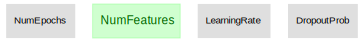

In [40]:
dj.Diagram(schema)

In [41]:
@schema
class Train(dj.Computed):
    definition = """
    -> NumFeatures
    -> DropoutProb
    -> LearningRate
    -> NumEpochs
    ---
    train_loss      : float
    model_weights   : longblob
    """
        
    def make(self, key):
        pass

In [42]:
Train()

"features_config_id so-called primary key, must be unique","dropout_config_id so-called primary key, must be unique","lr_config_id so-called primary key, must be unique","epochs_config_id so-called primary key, must be unique",train_loss,model_weights


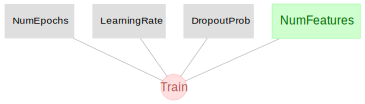

In [43]:
dj.Diagram(schema)

In [44]:
NumFeatures() * Train()

"features_config_id so-called primary key, must be unique","dropout_config_id so-called primary key, must be unique","lr_config_id so-called primary key, must be unique","epochs_config_id so-called primary key, must be unique",num_features_1,num_features_2,train_loss,model_weights


In [45]:
Train().drop()

[2023-04-25 19:14:43,350][INFO]: `tutorial`.`__train` (0 tuples)


Proceed? [yes, No]:  yes


[2023-04-25 19:14:44,719][INFO]: Dropped table `tutorial`.`__train`
[2023-04-25 19:14:44,731][INFO]: Tables dropped. Restart kernel.


In [46]:
NumFeatures()

"features_config_id so-called primary key, must be unique",num_features_1,num_features_2
1,32,32
2,16,32
3,32,64
4,64,64


In [47]:
@schema
class Train(dj.Computed):
    definition = """
    -> NumFeatures
    -> DropoutProb
    -> LearningRate
    -> NumEpochs
    ---
    train_loss      : float
    """
    
    class Weights(dj.Part):
        definition = """  # weights of the trained model
        -> Train
        layer    : varchar(64)   # layer name
        ---
        weights  : longblob      # numpy array of model weigths
        """
        
    def make(self, key):
        train_loader, test_loader = get_dataloaders(batch_size=64)
        
        num_features_1, num_features_2 = (NumFeatures() & key).fetch1("num_features_1", "num_features_2")
        dropout_prob = (DropoutProb() & key).fetch1("dropout_prob")
        lr = (LearningRate() & key).fetch1("lr")
        num_epochs = (NumEpochs() & key).fetch1("epochs")
        
        model = Net(num_features_1=num_features_1, num_features_2=num_features_2, dropout_prob=dropout_prob)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(1, num_epochs + 1):
            loss = train(model, train_loader, optimizer, epoch)
            
        key["train_loss"] = float(loss.detach().numpy())
        self.insert1(key)
        del key["train_loss"]
        
        for k, v in model.state_dict().items():
            key["layer"] = k
            key["weights"] = v.numpy()
            self.Weights.insert1(key)

In [48]:
Train().progress(display=True)

[2023-04-25 19:14:46,861][INFO]: Train                Completed 0 of 16 (0.0%)   2023-04-25 19:14:46


(16, 16)

In [49]:
Train().populate(max_calls=1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301472
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.295039
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.311407
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.300512
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.306663
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.309425
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.297946
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.312702
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.303078
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.299091


In [50]:
Train()

"features_config_id so-called primary key, must be unique","dropout_config_id so-called primary key, must be unique","lr_config_id so-called primary key, must be unique","epochs_config_id so-called primary key, must be unique",train_loss
1,1,2,1,2.30979


In [51]:
Train().progress(display=True)

[2023-04-25 19:15:27,508][INFO]: Train                Completed 1 of 16 (6.3%)   2023-04-25 19:15:27


(15, 16)

In [52]:
Train().Weights()

"features_config_id so-called primary key, must be unique","dropout_config_id so-called primary key, must be unique","lr_config_id so-called primary key, must be unique","epochs_config_id so-called primary key, must be unique",layer layer name,weights numpy array of model weigths
1,1,2,1,conv1.bias,=BLOB=
1,1,2,1,conv1.weight,=BLOB=
1,1,2,1,conv2.bias,=BLOB=
1,1,2,1,conv2.weight,=BLOB=
1,1,2,1,fc1.bias,=BLOB=
1,1,2,1,fc1.weight,=BLOB=
1,1,2,1,fc2.bias,=BLOB=
1,1,2,1,fc2.weight,=BLOB=


In [53]:
Train().Weights() & dict(layer="conv2.bias")

"features_config_id so-called primary key, must be unique","dropout_config_id so-called primary key, must be unique","lr_config_id so-called primary key, must be unique","epochs_config_id so-called primary key, must be unique",layer layer name,weights numpy array of model weigths
1,1,2,1,conv2.bias,=BLOB=


In [54]:
(Train().Weights() & dict(layer="conv2.bias")).fetch1("weights")

array([-0.10307139, -0.08073657, -0.10773873, -0.02578883, -0.02786762,
       -0.05198716, -0.02176897, -0.0466007 , -0.04605456, -0.06268577,
       -0.06745198, -0.06557348, -0.11862184, -0.10004321, -0.08686852,
       -0.10275701, -0.03789702, -0.06232484, -0.11322562, -0.10462096,
       -0.05315004, -0.03770746, -0.02087278, -0.03803886, -0.01050316,
       -0.06845255, -0.04362513, -0.08462683, -0.09823405, -0.09004518,
       -0.01816215, -0.01126364], dtype=float32)

In [55]:
Train().Weights().fetch(as_dict=True)

[{'features_config_id': 1,
  'dropout_config_id': 1,
  'lr_config_id': 2,
  'epochs_config_id': 1,
  'layer': 'conv1.bias',
  'weights': array([-0.31935763, -0.11066564, -0.21622226, -0.05833106, -0.3831852 ,
          0.25436428,  0.15482643,  0.11579075, -0.22021902, -0.2733959 ,
          0.04900852, -0.30479494,  0.28494015, -0.12083602, -0.3947046 ,
         -0.1947041 ,  0.24651305, -0.26678064,  0.23653384,  0.14286023,
          0.17062037, -0.09738769,  0.17896175,  0.22127801, -0.2409431 ,
          0.27290004,  0.11260919, -0.27363387,  0.25557604, -0.03483531,
          0.04234095,  0.01979419], dtype=float32)},
 {'features_config_id': 1,
  'dropout_config_id': 1,
  'lr_config_id': 2,
  'epochs_config_id': 1,
  'layer': 'conv1.weight',
  'weights': array([[[[ 9.84333828e-02,  2.92270809e-01, -2.09996104e-01],
           [-6.75828904e-02,  1.51782379e-01, -2.25927353e-01],
           [-3.61601174e-01, -2.90225416e-01,  2.16073799e-03]]],
  
  
         [[[ 1.59069851e-01, -6

### Parallel jobs

In [57]:
schema.jobs

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp
__train,571e0f7e2d992e738adff8b1bd43a521,error,=BLOB=,KeyboardInterrupt,=BLOB=,root@172.17.0.1,Ivans-MacBook-Air.local,85740,11,2023-04-25 16:16:02
__train,b59c67bf196a4758191e42f76670ceba,reserved,=BLOB=,,=BLOB=,root@172.17.0.1,Ivans-MacBook-Air.local,85740,11,2023-04-25 16:16:16
__train,f6e794a75c5d51de081dbefa224304f9,reserved,=BLOB=,,=BLOB=,root@172.17.0.1,Ivans-MacBook-Air.local,85761,12,2023-04-25 16:16:17
__train,f7f580e11d00a75814d2ded41fe8e8fe,error,=BLOB=,RuntimeError: File not found or corrupted.,=BLOB=,root@172.17.0.1,Ivans-MacBook-Air.local,85740,11,2023-04-25 16:16:16
__train,fe709c654eac84d5239d1a12a4f71877,error,=BLOB=,RuntimeError: File not found or corrupted.,=BLOB=,root@172.17.0.1,Ivans-MacBook-Air.local,85761,12,2023-04-25 16:16:17


In [58]:
print(schema.jobs.fetch("error_stack", limit=1)[0])

Traceback (most recent call last):
  File "/Users/ivust/TU_Dortmund/Projects/DataJoint_Tutorial/.venv/lib/python3.11/site-packages/datajoint/autopopulate.py", line 292, in _populate1
    make(dict(key), **(make_kwargs or {}))
  File "/Users/ivust/TU_Dortmund/Projects/DataJoint_Tutorial/datajoint_tutorial/schema.py", line 64, in make
    train_loader, test_loader = get_dataloaders(batch_size=64)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ivust/TU_Dortmund/Projects/DataJoint_Tutorial/datajoint_tutorial/torch_network.py", line 75, in get_dataloaders
    dataset1 = datasets.MNIST('data', train=True, download=True,
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ivust/TU_Dortmund/Projects/DataJoint_Tutorial/.venv/lib/python3.11/site-packages/torchvision/datasets/mnist.py", line 99, in __init__
    self.download()
  File "/Users/ivust/TU_Dortmund/Projects/DataJoint_Tutorial/.venv/lib/python3.11/site-packages/torchvision/datas

In [59]:
schema.jobs.fetch("key")

array([{'features_config_id': 3, 'dropout_config_id': 1, 'lr_config_id': 2, 'epochs_config_id': 1},
       {'features_config_id': 1, 'dropout_config_id': 1, 'lr_config_id': 1, 'epochs_config_id': 1},
       {'features_config_id': 3, 'dropout_config_id': 2, 'lr_config_id': 2, 'epochs_config_id': 1},
       {'features_config_id': 4, 'dropout_config_id': 1, 'lr_config_id': 1, 'epochs_config_id': 1},
       {'features_config_id': 3, 'dropout_config_id': 1, 'lr_config_id': 1, 'epochs_config_id': 1}],
      dtype=object)

In [67]:
Train()

"features_config_id so-called primary key, must be unique","dropout_config_id so-called primary key, must be unique","lr_config_id so-called primary key, must be unique","epochs_config_id so-called primary key, must be unique",train_loss
1,1,1,1,0.0685394
1,1,2,1,2.30979
1,2,1,1,0.018592
2,1,1,1,0.00668384
2,2,2,1,0.152021
3,2,1,1,0.00224125
3,2,2,1,0.214565
4,2,2,1,0.524754


In [68]:
best_loss_key = Train().fetch("KEY", order_by="train_loss", limit=1)

In [69]:
best_loss_key

[{'features_config_id': 3,
  'dropout_config_id': 2,
  'lr_config_id': 1,
  'epochs_config_id': 1}]

In [70]:
Train() & best_loss_key

"features_config_id so-called primary key, must be unique","dropout_config_id so-called primary key, must be unique","lr_config_id so-called primary key, must be unique","epochs_config_id so-called primary key, must be unique",train_loss
3,2,1,1,0.00224125


In [71]:
Train() * NumFeatures() * DropoutProb() & best_loss_key

"features_config_id so-called primary key, must be unique","dropout_config_id so-called primary key, must be unique","lr_config_id so-called primary key, must be unique","epochs_config_id so-called primary key, must be unique",train_loss,num_features_1,num_features_2,dropout_prob
3,2,1,1,0.00224125,32,64,0.5


In [72]:
Train().Weights() & best_loss_key

"features_config_id so-called primary key, must be unique","dropout_config_id so-called primary key, must be unique","lr_config_id so-called primary key, must be unique","epochs_config_id so-called primary key, must be unique",layer layer name,weights numpy array of model weigths
3,2,1,1,conv1.bias,=BLOB=
3,2,1,1,conv1.weight,=BLOB=
3,2,1,1,conv2.bias,=BLOB=
3,2,1,1,conv2.weight,=BLOB=
3,2,1,1,fc1.bias,=BLOB=
3,2,1,1,fc1.weight,=BLOB=
3,2,1,1,fc2.bias,=BLOB=
3,2,1,1,fc2.weight,=BLOB=


### Results consistency

In [73]:
DropoutProb()

"dropout_config_id so-called primary key, must be unique",dropout_prob
1,0.25
2,0.5


In [74]:
Train()

"features_config_id so-called primary key, must be unique","dropout_config_id so-called primary key, must be unique","lr_config_id so-called primary key, must be unique","epochs_config_id so-called primary key, must be unique",train_loss
1,1,1,1,0.0685394
1,1,2,1,2.30979
1,2,1,1,0.018592
1,2,2,1,0.579606
2,1,1,1,0.00668384
2,1,2,1,0.275638
2,2,1,1,0.151909
2,2,2,1,0.152021
3,2,1,1,0.00224125
3,2,2,1,0.214565


In [75]:
DropoutProb() & "dropout_prob = 0.5"

"dropout_config_id so-called primary key, must be unique",dropout_prob
2,0.5


In [76]:
(DropoutProb() & "dropout_prob = 0.5").delete()

[2023-04-25 19:21:11,495][INFO]: Deleting 56 rows from `tutorial`.`__train__weights`
[2023-04-25 19:21:11,503][INFO]: Deleting 7 rows from `tutorial`.`__train`
[2023-04-25 19:21:11,512][INFO]: Deleting 1 rows from `tutorial`.`#dropout_prob`


Commit deletes? [yes, No]:  yes


[2023-04-25 19:21:13,249][INFO]: Deletes committed.


1

In [77]:
Train()

"features_config_id so-called primary key, must be unique","dropout_config_id so-called primary key, must be unique","lr_config_id so-called primary key, must be unique","epochs_config_id so-called primary key, must be unique",train_loss
1,1,1,1,0.0685394
1,1,2,1,2.30979
2,1,1,1,0.00668384
2,1,2,1,0.275638
4,1,2,1,2.30982
